<a href="https://www.kaggle.com/code/bensonduong/font-type-image-classification?scriptVersionId=104997089" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Typeface Categorization using Unsupervised Learning, Convolutional Neural Network, and OpenCV**
* This data science computer vision project will be about categorizing fonts into groups based on visual attrbutes, from photoscanned images of paper text.
* The font categorization will be in terms of general "font types", *not* specific typefaces (like Arial, Times New Roman, etc.), but moreso categories like "serifed", "san-serifed", "cursive", etc.
* These font categories will be initially grouped through **Unsupervised Learning**, like **Principal Component Analysis Eigen-decomposition**, and specifically **Spectral Embedding**, finally designated with **K-means Clustering**. 
* This dataset in turn uses actual typefaces from the UC Irvine Font Dataset https://archive.ics.uci.edu/ml/datasets/Character+Font+Images
* These labellings will be used for training a **convolutional neural network** with variable-input-size, meaning it can classify the general font types of completely new and unseen typefaces. This CNN will allow variable input size for the versatile dimensions of the incoming segmented characters.
* Using OpenCV, photo-scanned images of text will be inputted, undergo character image segmentation, and have its font types classified.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
import seaborn as sns

plt.rcParams['figure.figsize'] = (7,7)

In [2]:
import sklearn.decomposition
from sklearn.preprocessing import normalize
import sklearn.neighbors
import sklearn.manifold
from sklearn.cluster import KMeans

from tqdm import tqdm

In [3]:
import cv2
import urllib.request
from tensorflow import keras
import tensorflow as tf
from keras.optimizers import adam_v2

In [4]:
file_names = []
file_paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath = (os.path.join(dirname, filename))
        file_paths.append(filepath)
        file_names.append(filename)

In [5]:
def prepare_font_df(font_df_orig):
    # For each font's csv table, the column "m_label" denotes an identifier for a certain character
    # The variables below are the m_labels for specific character groups (alphanumeric - uppercase, lowercase, digits)
    MIN_M_LABEL = 33
    MAX_M_LABEL = 126
    m_labels_all = list(range(MIN_M_LABEL,MAX_M_LABEL+1))
    m_labels_alphanum_alpha_upper = list(range(m_labels_all[32], m_labels_all[32+26]))
    m_labels_alphanum_alpha_lower = list(range(m_labels_all[64], m_labels_all[64+26]))
    m_labels_alphanum_num = list(range(m_labels_all[16], m_labels_all[16+10]))

    CHOSEN_M_LABELS = []
    CHOSEN_M_LABELS += m_labels_alphanum_alpha_upper
    #CHOSEN_M_LABELS += m_labels_alphanum_alpha_lower
    #CHOSEN_M_LABELS += m_labels_alphanum_num

    curr_font_df = font_df_orig
    
    ERROR_FONTS = ['BITSTREAMVERA','CREDITCARD', 'E13B', 'HANDPRINT', 'MONEY', 'NUMERICS', 'VIN']
    curr_font_df = curr_font_df[curr_font_df["font"].isin(ERROR_FONTS)==False]
    # Remove Errored Fonts
    curr_font_df = curr_font_df[curr_font_df["fontVariant"]!="scanned"]
    # Removed Scanned Pictures
    curr_font_df = curr_font_df[curr_font_df["m_label"].isin(CHOSEN_M_LABELS)] 
    # get the chosen labels 
    curr_font_df = curr_font_df.sort_values(["font","m_label"]) 
    # make sure that the characters are in order, which is necessary for a horizontal concatenation and consistent embedding later on.
    curr_font_df = curr_font_df[curr_font_df["strength"] <= 0.5] 
    # remove bolded
    curr_font_df = curr_font_df[curr_font_df["italic"] <= 0.5] 
    # remove italicized
    curr_font_df = curr_font_df.drop_duplicates(subset=["font","m_label","strength","italic"]) 
    curr_font_df = curr_font_df.sort_values(["font","m_label"])
    return curr_font_df

In [6]:
uci_font_family_csv_file_names = file_names
range_len_uci_font_family_csv_file_names = range(len(uci_font_family_csv_file_names))
range_len_uci_font_family_csv_file_names = tqdm(range_len_uci_font_family_csv_file_names)

font_df_concat_list = []

for i in range_len_uci_font_family_csv_file_names:
    #if (((i+1)%25)==0): print(i+1, len(uci_font_family_csv_file_names));
    uci_font_family_csv_file_name = uci_font_family_csv_file_names[i]
    uci_font_family = uci_font_family_csv_file_name.split(".csv")[0]
    # uci_font_family_csv_file_path = font_folder_path + uci_font_family_csv_file_name
    uci_font_family_csv_file_path = file_paths[i]
    temp_uci_font_family_df_orig = pd.read_csv(uci_font_family_csv_file_path)
    temp_uci_font_family_df_orig = prepare_font_df(temp_uci_font_family_df_orig)
    font_df_concat_list.append(temp_uci_font_family_df_orig)

100%|██████████| 153/153 [01:06<00:00,  2.31it/s]


In [7]:
font_df_orig = pd.concat(font_df_concat_list, axis=0)

In [8]:
print("font_df_orig.shape = ",font_df_orig.shape)

font_df_orig.head(5)
#font_df_orig.shape =  (832670, 412)

font_df_orig.shape =  (3796, 412)


,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
361,SKETCHFLOW,SKETCHFLOW PRINT,65,0.4,0,0.0,26,21,53,43,...,1,1,1,1,1,30,229,255,126,1
360,SKETCHFLOW,SKETCHFLOW PRINT,66,0.4,0,0.0,31,26,46,46,...,1,1,1,1,1,1,1,1,1,1
359,SKETCHFLOW,SKETCHFLOW PRINT,67,0.4,0,0.0,31,22,45,44,...,1,1,1,1,1,1,1,1,1,1
358,SKETCHFLOW,SKETCHFLOW PRINT,68,0.4,0,0.0,29,24,48,43,...,1,1,1,1,1,1,1,1,1,1
357,SKETCHFLOW,SKETCHFLOW PRINT,69,0.4,0,0.0,30,27,45,42,...,14,1,1,1,1,1,1,1,1,1


* You can change which characters you want to use in the CHOSEN_M_LABELS variable . 
* But for this unsupervised classification, I'm going to just use the 26 capital letters to represent each font
* My main reason is that most capital letters are arguably square-shaped and thus proportionally consistent in anatomy for most fonts. In this dataset, thin or wide characters (like lowercase, numbers, and punctuation) get forcibly stretched or narrowed to fit a 20x20 space, making it inconsistent.
* We also removed error prone fonts
* Removed badly photoscanned pictures
* De-italicize
* Un-emboldened
* Removed Duplicates

In [9]:
# each row of the csv table has a 20x20 image for the character it represents, 
# which can be made using a group of 400 columns. These column names are collected here for future use
pixel_column_names = []
for i in range(0, 20):
    for j in range(0, 20):
        pixel_column_name = "r{0}c{1}".format(str(i),str(j))
        pixel_column_names.append(pixel_column_name)

In [10]:
assert np.all(font_df_orig["font"].value_counts()==26)
unraveled_alphabets = font_df_orig[pixel_column_names].values.reshape(3796//26, 20*20*26)

In [52]:
passed_font_families = list(font_df_orig["font"].drop_duplicates())

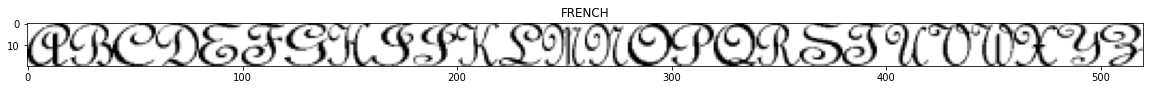

In [11]:
# demonstration of using the font_visualization list
GIVEN_FONT = "FRENCH" # input any font from the dataset, make sure it's in capital letters

def get_alphabet_array_of_font(GIVEN_FONT):
    given_font_index = passed_font_families.index(GIVEN_FONT)
    alphabet_image = np.hstack(unraveled_alphabets[given_font_index].reshape((26,20,20)))
    return alphabet_image
def plot_font(GIVEN_FONT):
    fig_temp, ax_temp = plt.subplots(figsize=(20,20))
    alphabet_image = get_alphabet_array_of_font(GIVEN_FONT)
    plt.imshow(255-alphabet_image, cmap="gray")
    plt.title(GIVEN_FONT)
plot_font(GIVEN_FONT)

## **Unsupervised Grouping of Fonts**
Different methods to group the fonts will be used;
1. Principal Component Analysis ("eigen-fonts")
2. Spectral Embeddings built from the similiarity matrix (normalized gram matrix)
3. Spectral Embeddings built from the sklearn.neighbors.kneighbors_graph

In [52]:
eig_fonts_x = np.array(unraveled_alphabets)
# eig_fonts_x.shape # is (147, 10400)

#### 1. Principal Component Analysis ("Eigen-Fonts")

In [58]:
eig_fonts_x = np.array(unraveled_alphabets).astype(np.float32)
eig_fonts_x /= 255
#C = np.cov(eig_fonts_x.T)
#eigvals, eigvecs = np.linalg.eigh(C)
#N_EIGENVALUES = 10
#top_n_eigfonts_eigvecs = eigvecs[:, -N_EIGENVALUES:]
from sklearn.decomposition import PCA
eigvecs = PCA(10).fit_transform(eig_fonts_x.T)
#eigvecs = np.abs(eigvecs)#[:,0].shape

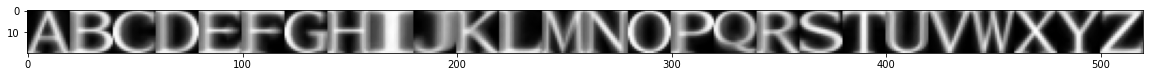

In [59]:
u = eigvecs[:, 0]
fig_temp, ax_temp = plt.subplots(figsize=(20,20))
temp_font_unraveled = u
temp_font = np.hstack(temp_font_unraveled.reshape(26,20,20))#.shape
plt.imshow(temp_font, cmap="gray")

**Plotting each eigenvector shows a specific "group" of font.**
* The "typeface" plotted above doesn't actually exist, it is actually the largest eigenvector, completely autogenerated from our own data. As you can see, it looks like a serifed font.

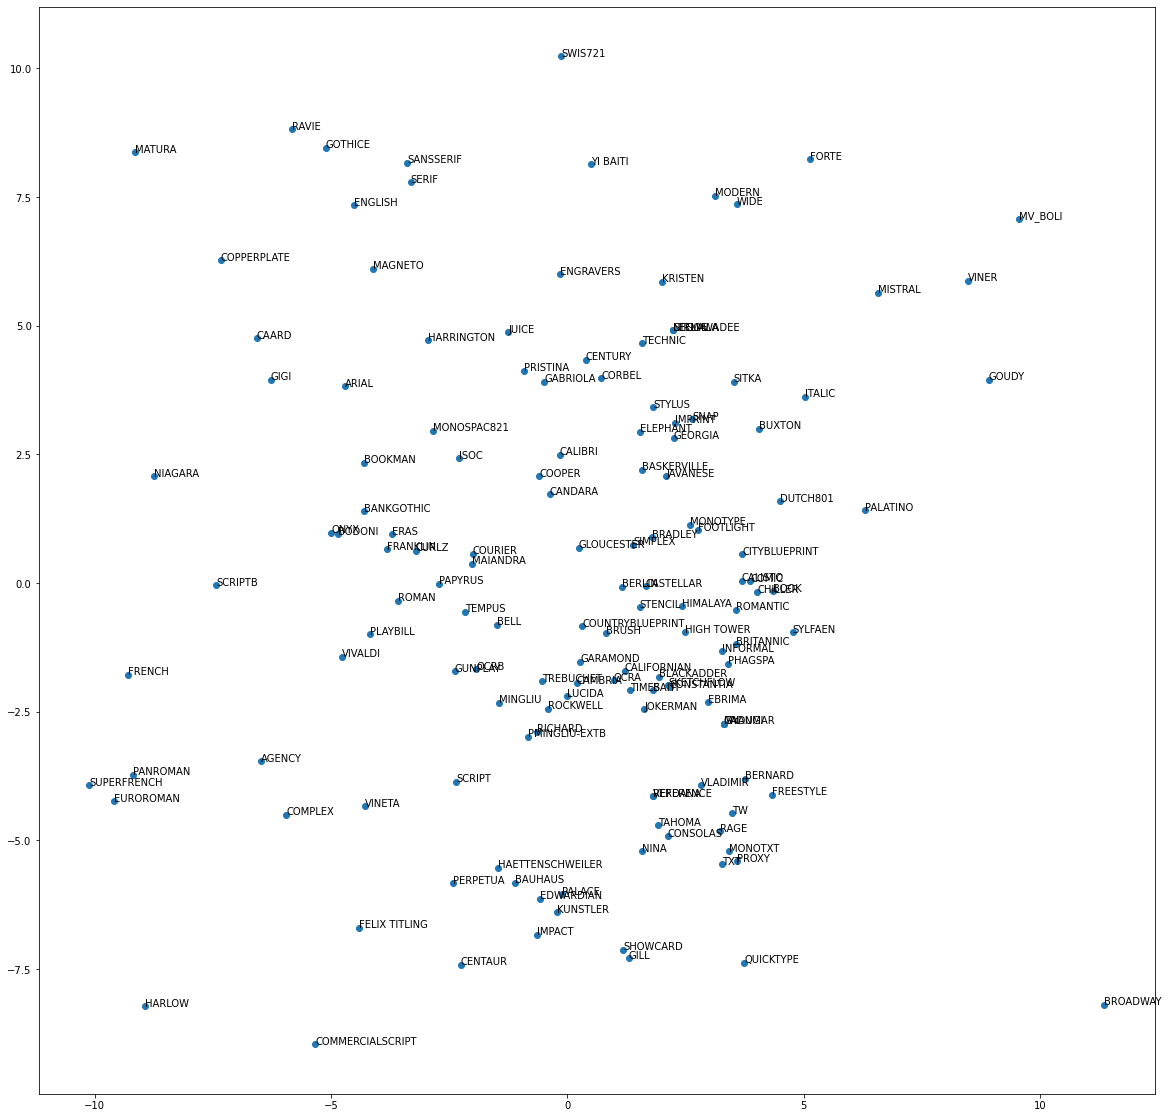

In [60]:
eig_fonts_x = np.array(unraveled_alphabets).astype(np.float32)
eig_fonts_x /= 255
#C = np.cov(eig_fonts_x.T)
#eigvals, eigvecs = np.linalg.eigh(C)
#N_EIGENVALUES = 10
#top_n_eigfonts_eigvecs = eigvecs[:, -N_EIGENVALUES:]
from sklearn.decomposition import PCA
eigvecs = PCA(10).fit_transform(eig_fonts_x)
#eigvecs = np.abs(eigvecs)#[:,0].shape

# embedding.shape
x = eigvecs[:,-1]
y = eigvecs[:,-2]
n = passed_font_families

fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

#### 2. Spectral Embedding built from a Similarity Matrix (Normalized Gramian Matrix)

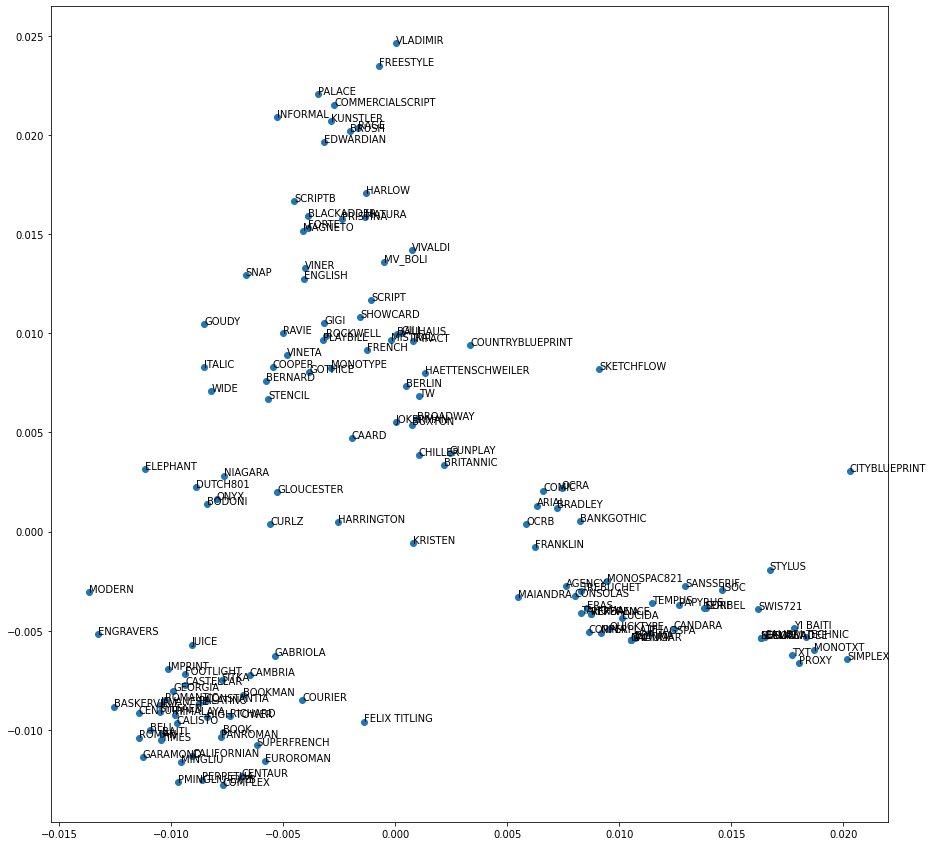

In [61]:
eig_fonts_x_normalized = normalize(eig_fonts_x, axis=1) #
eig_fonts_similarity_matrix = eig_fonts_x_normalized @ eig_fonts_x_normalized.T
W = eig_fonts_similarity_matrix

N_EMBEDDINGS = 2
embedding = sklearn.manifold.spectral_embedding(W, n_components=N_EMBEDDINGS)

# embedding.shape
x = embedding[:,0]
y = embedding[:,1]
n = passed_font_families
            
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

* After the use of spectral embedding, we can clearly see some well defined clusters. 
  * Serifed Fonts like Garamond and Cambria are clumped on the bottom left.
  * San-Serifed Fonts like Segoe and Bank Gothic are clumped on the right
  * Scripted or Decorative Fonts like Blackadder and Edwardian are clumped on the top

* Fonts from the right cluster seems to be  san serif fonts

Visualizing fonts from the right cluster seem to show San Serif fonts


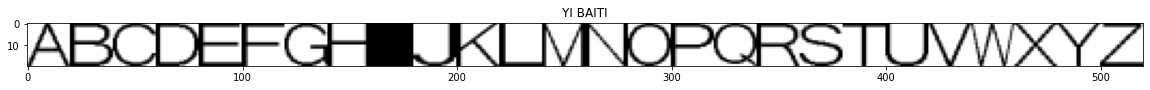

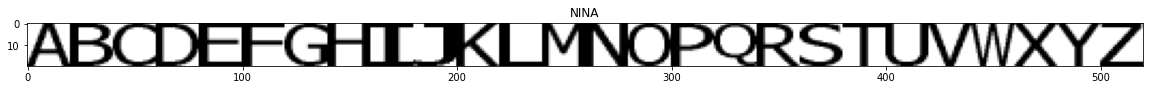

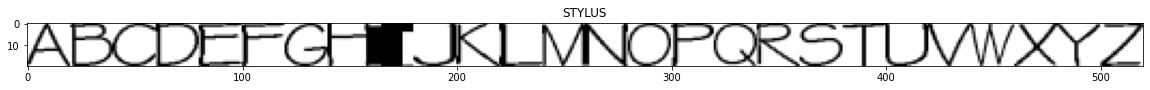

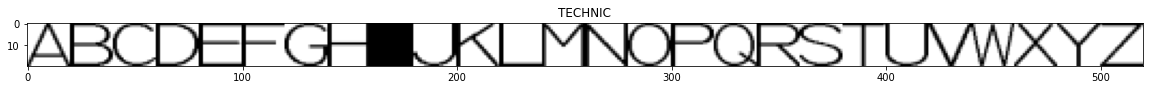

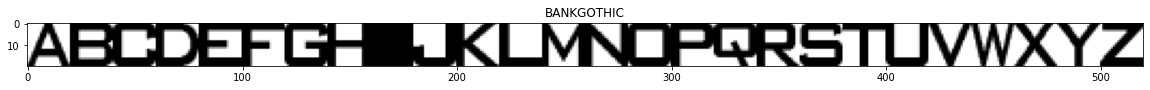

In [62]:
print("Visualizing fonts from the right cluster seem to show San Serif fonts")
plot_font("YI BAITI")
plot_font("NINA")
plot_font("STYLUS")
plot_font("TECHNIC")
plot_font("BANKGOTHIC")


* Fonts from the Bottom Left cluster seems to be serif fonts

Visualizing fonts from the Bottom Left cluster seems to show serif fonts


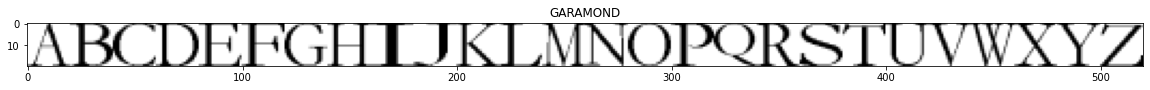

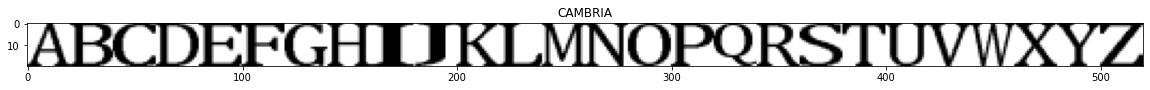

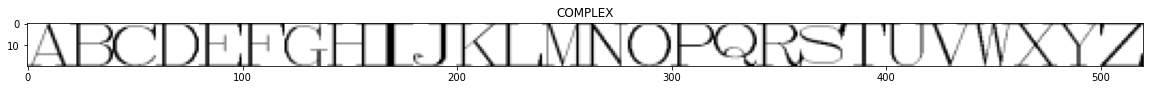

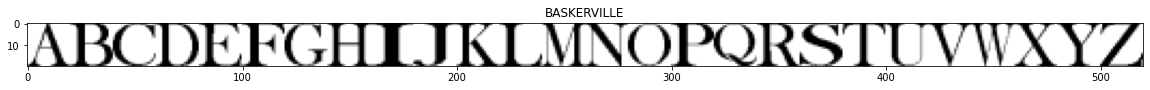

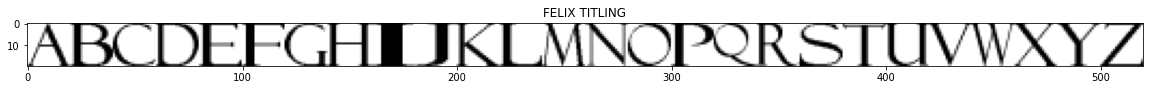

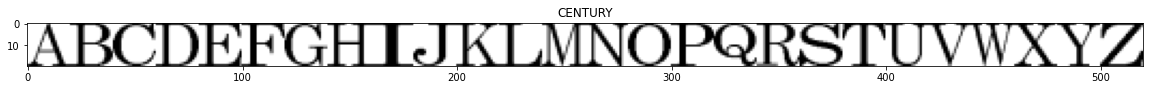

In [64]:
print("Visualizing fonts from the Bottom Left cluster seems to show serif fonts")
plot_font("GARAMOND")
plot_font("CAMBRIA")
plot_font("COMPLEX")
plot_font("BASKERVILLE")
plot_font("FELIX TITLING")
plot_font("CENTURY")

* Fonts from the Top cluster seems to be hand-written fonts. And it seems to be mixed of many overlapping subgroups: 
    * Fonts that are old-fashioned calligraphic script, such as cursive, 
    * Fonts that are just everyday messy handwriting
    * Sometimes, the everyday handwriting subgroup and cursive subgroup overlap, like in the font "Vladimir"

* Visualizing the subgroup of fonts in the top cluster that have an elegant calligraphic style to it. A lot have a cursive-look to it.

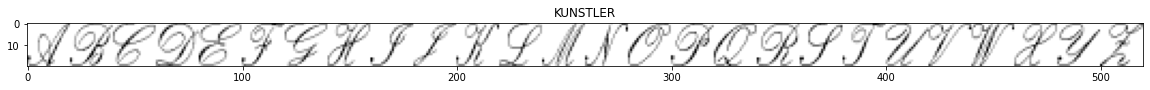

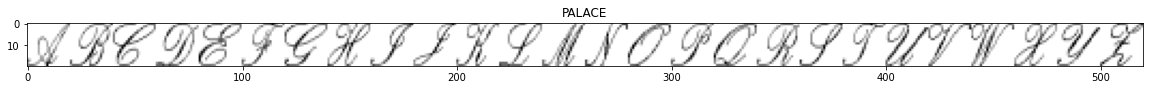

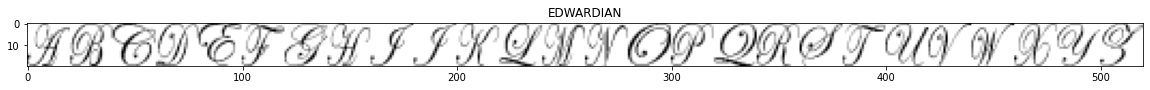

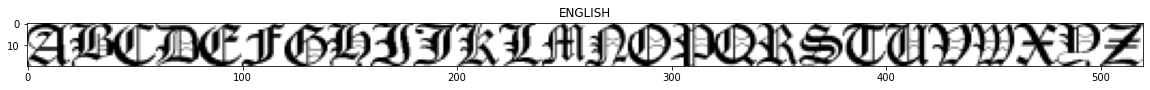

In [65]:
plot_font("KUNSTLER")
plot_font("PALACE")
plot_font("EDWARDIAN")
plot_font("ENGLISH")

* Visualizing the subgroup of fonts in the top cluster that have a messy, everyday handwriting style to it.

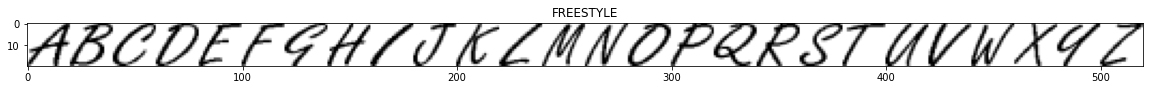

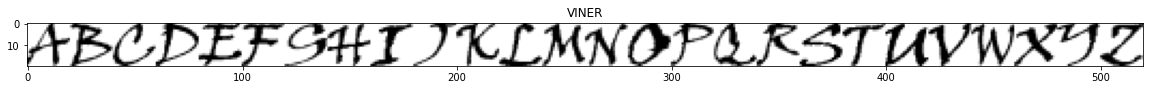

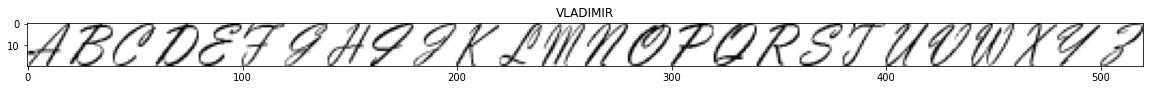

In [66]:
plot_font("FREESTYLE")
plot_font("VINER")
plot_font("VLADIMIR")

* Finally, the fonts from the middle cluster seem to be the overlaps of the 3 clusters, or otherwise their own category. These can mostly involve decorative fonts.
    * In case Curlz is hard to find, it's to the immediate left of Harrington, paired with Courier
    * Jokerman and Broadway are clumped together, and are to the immediate right of Caard

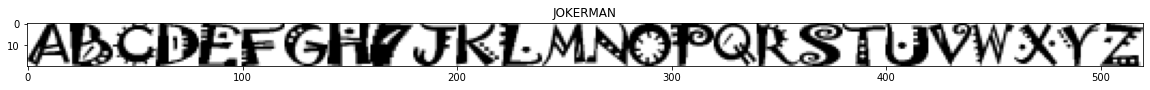

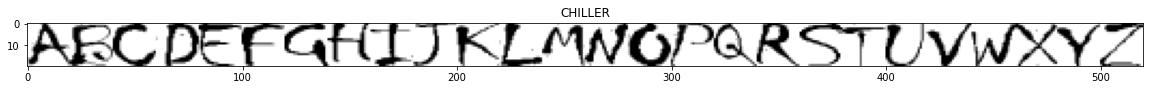

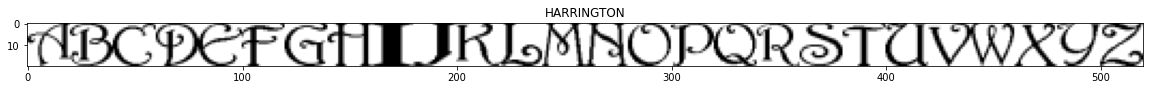

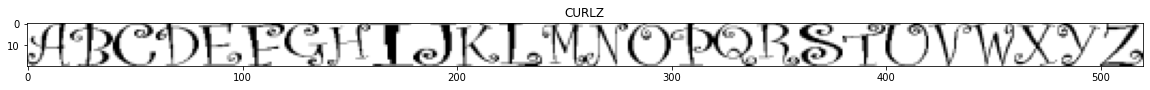

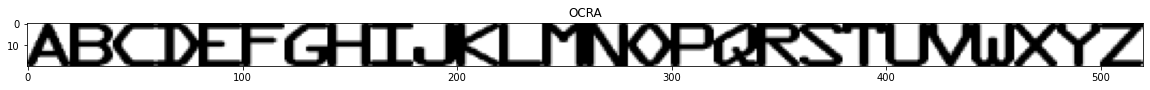

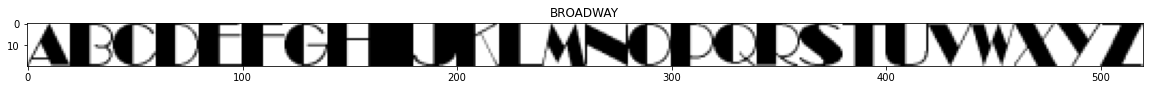

In [67]:
plot_font("JOKERMAN")
plot_font("CHILLER")
plot_font("HARRINGTON")
plot_font("CURLZ")
plot_font("OCRA")
plot_font("BROADWAY")

* Overall, this is very cluster-able, but the overlaps will inhibit being able to easily categorize them. We'll try 1 more method

In [78]:
N_CLUSTERS = 3
np.random.seed(1)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(eigfont_embeddings_df[embedding_column_names])
kmeans.labels_

eigfont_embeddings_df["cluster"] = kmeans.labels_

# Another thing we can do is to be less discrete with grouping the fonts. 
# Instead being binary, this part will ambiguously decide how each font can be grouped under each cluster group as a proportion, based on the distance to the cluster centroid

cluster_center_i_distance_column_names = []
for i in range(N_CLUSTERS):
    cluster_center_i = kmeans.cluster_centers_[i]

    cluster_center_i_distance = 0
    for j in range(N_EMBEDDINGS):
        cluster_center_i_distance += (eigfont_embeddings_df["embedding_{0}".format(j)] - cluster_center_i[j])**2
    cluster_center_i_distance_column_name = "cluster_center_{0}_distance".format(i)
    cluster_center_i_distance_column_names.append(cluster_center_i_distance_column_name)
    eigfont_embeddings_df[cluster_center_i_distance_column_name] = cluster_center_i_distance

eigfont_embeddings_df_cluster_center_i_distance = eigfont_embeddings_df[cluster_center_i_distance_column_names]
#((eigfont_embeddings_df_cluster_center_i_distance)*-1).add(eigfont_embeddings_df_cluster_center_i_distance.max(axis=1),axis="index")

#(0.5*(1-(normalize(eigfont_embeddings_df_cluster_center_i_distance, axis=1,norm="l1"))))#.sum(axis=1)
eigfont_embeddings_df_cluster_center_i_distance = 1/eigfont_embeddings_df_cluster_center_i_distance
eigfont_embeddings_df_cluster_center_i_proximity = normalize(eigfont_embeddings_df_cluster_center_i_distance,axis=1,norm="l1")
eigfont_embeddings_df[cluster_center_i_distance_column_names] = eigfont_embeddings_df_cluster_center_i_proximity
eigfont_embeddings_df = eigfont_embeddings_df.rename(columns=dict([("cluster_center_{0}_distance", "cluster_center_{0}_proximity") for i in range(N_CLUSTERS)]))

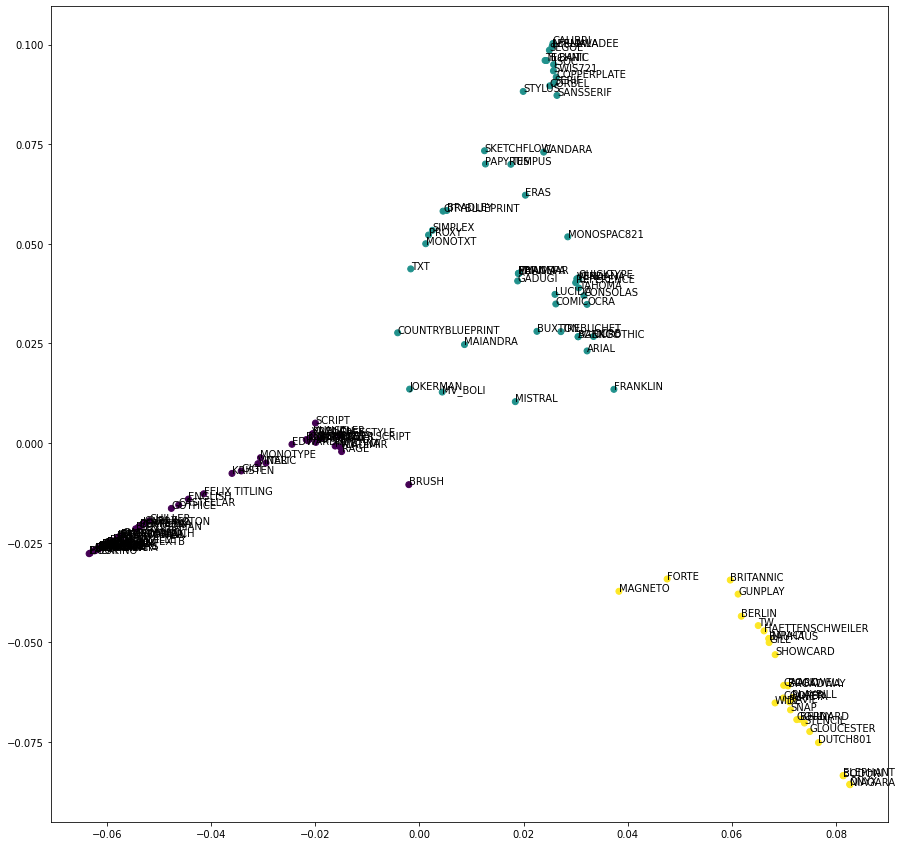

In [79]:
x = eigfont_embeddings_df["embedding_0"]
y = eigfont_embeddings_df["embedding_1"]
fonts = eigfont_embeddings_df["font"]
            
colors=eigfont_embeddings_df["cluster"]
#colors=((eigfont_embeddings_df_cluster_center_i_proximity)*255).astype(int)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.scatter(x, y,c=colors)

for i, txt in enumerate(fonts):
    ax.annotate(txt, (x[i], y[i]))

In [80]:
group_first = eigfont_embeddings_df[eigfont_embeddings_df["cluster"]==0].sort_values(["cluster_center_0_distance"],
                                                                                    ascending=False)["font"].values
group_second = eigfont_embeddings_df[eigfont_embeddings_df["cluster"]==1].sort_values(["cluster_center_1_distance"],
                                                                                     ascending=False)["font"].values
group_third = eigfont_embeddings_df[eigfont_embeddings_df["cluster"]==2].sort_values(["cluster_center_2_distance"],
                                                                                    ascending=False)["font"].values

In [81]:
group_first

array(['CASTELLAR', 'GOTHICE', 'ENGLISH', 'FELIX TITLING', 'CHILLER',
       'CURLZ', 'HARRINGTON', 'PERPETUA', 'COMPLEX', 'CENTAUR',
       'EUROROMAN', 'GARAMOND', 'SUPERFRENCH', 'PANROMAN', 'CALIFORNIAN',
       'SITKA', 'HIGH TOWER', 'IMPRINT', 'ROMAN', 'BASKERVILLE',
       'KRISTEN', 'BELL', 'PMINGLIU-EXTB', 'JUICE', 'MINGLIU', 'GEORGIA',
       'FOOTLIGHT', 'BOOKMAN', 'COURIER', 'GABRIOLA', 'TIMES', 'CENTURY',
       'BAITI', 'JAVANESE', 'MODERN', 'ENGRAVERS', 'CALISTO', 'CAMBRIA',
       'GIGI', 'HIMALAYA', 'ROMANTIC', 'RICHARD', 'CONSTANTIA', 'SYLFAEN',
       'BOOK', 'PALATINO', 'VINER', 'MONOTYPE', 'ITALIC', 'EDWARDIAN',
       'BLACKADDER', 'PALACE', 'COMMERCIALSCRIPT', 'INFORMAL', 'MATURA',
       'VIVALDI', 'FRENCH', 'KUNSTLER', 'SCRIPTB', 'HARLOW', 'PRISTINA',
       'SCRIPT', 'RAGE', 'VLADIMIR', 'FREESTYLE', 'BRUSH'], dtype=object)

In [82]:
group_second

array(['ERAS', 'MONOSPAC821', 'TAI', 'PHAGSPA', 'EBRIMA', 'MYANMAR',
       'TEMPUS', 'GADUGI', 'PAPYRUS', 'BRADLEY', 'CANDARA', 'QUICKTYPE',
       'CITYBLUEPRINT', 'VERDANA', 'NINA', 'REFERENCE', 'SKETCHFLOW',
       'SIMPLEX', 'TAHOMA', 'LUCIDA', 'PROXY', 'MONOTXT', 'CONSOLAS',
       'COMIC', 'OCRA', 'SANSSERIF', 'STYLUS', 'CORBEL', 'SERIF',
       'COPPERPLATE', 'TXT', 'SWIS721', 'ISOC', 'YI BAITI', 'TECHNIC',
       'BUXTON', 'TREBUCHET', 'SEGOE', 'LEELAWADEE', 'NIRMALA', 'CALIBRI',
       'BANKGOTHIC', 'AGENCY', 'OCRB', 'ARIAL', 'MAIANDRA',
       'COUNTRYBLUEPRINT', 'FRANKLIN', 'MISTRAL', 'MV_BOLI', 'JOKERMAN'],
      dtype=object)

In [83]:
group_third

array(['CAARD', 'ROCKWELL', 'BROADWAY', 'COOPER', 'PLAYBILL', 'VINETA',
       'WIDE', 'RAVIE', 'SNAP', 'SHOWCARD', 'GOUDY', 'BERNARD', 'STENCIL',
       'GILL', 'BAUHAUS', 'IMPACT', 'GLOUCESTER', 'HAETTENSCHWEILER',
       'DUTCH801', 'TW', 'BERLIN', 'ELEPHANT', 'BODONI', 'ONYX',
       'NIAGARA', 'GUNPLAY', 'BRITANNIC', 'FORTE', 'MAGNETO'],
      dtype=object)

**Results of Clustering**
* After running the math, the 3 groups/clusters of fonts are shown above:
    * The first group seems to be serifed fonts, like Bookman, Baskerville, Courier, Cambria, Garamond, etc.
    * The second group seems to be san-serifed fonts, like Arial, Impact, Ebrima, etc.
    * The third group seems to be "handwritten fonts". These include "cursive fonts" Like Blackadder, Edwardian, Monotype, or scribe fonts like Chiller and Papyrus.
* Of course, it's not quite perfect. Some fonts show up in the wrong groups. Like Elephant showing up in the sans-serif group


We can finally create the training and testing dataset. This will be similar to the very first csv-reading iteration for loop, except that:
* We will include all characters; for this case, those are lowercase and number characters
* The cluster groupings are now the y's
* The x's are individual 20x20 images of the characters

## **Building the Convolutional Neural Network**


In [ ]:
x_train = []
x_test = []
y_train = []
y_test = []

font_folder_path = '/kaggle/input/uci-fonts-dataset/'
range_len_passed_font_families = range(len(passed_font_families))
range_len_passed_font_families = tqdm(range_len_passed_font_families)
for i in range_len_passed_font_families:
    passed_font_family = passed_font_families[i]
    #if (((i+1)%25)==0): print(i+1, len(passed_font_families));
    uci_font_family_csv_file_name = passed_font_family + ".csv"
    uci_font_family_csv_file_path = font_folder_path + uci_font_family_csv_file_name
    temp_uci_font_family_df_orig = pd.read_csv(uci_font_family_csv_file_path)
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.sort_values("m_label")#.value_counts()
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["m_label"].isin(m_labels_alphanum_alpha_upper+m_labels_alphanum_alpha_lower+m_labels_alphanum_num)]
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["strength"] <= 0.5]
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["italic"] <= 0.5]
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.drop_duplicates(subset=["m_label","strength","italic"])
    assert temp_uci_font_family_df_orig.shape[0] <= 26+26+50
    temp_uci_font_family_df_pixels = temp_uci_font_family_df_orig[pixel_column_names]

    train_test = np.random.choice([1,0],size=len(temp_uci_font_family_df_pixels), p=[0.75, 0.25])
    train_character_pics_flattened= temp_uci_font_family_df_pixels[train_test.astype(bool)]
    train_character_pics_reshaped = train_character_pics_flattened.values.reshape(train_character_pics_flattened.shape[0],20,20)

    train_ohe = eigfont_embeddings_df[eigfont_embeddings_df["font"]==passed_font_family][cluster_center_i_distance_column_names].values
    train_ohes = np.tile(train_ohe[0],(train_character_pics_flattened.shape[0],1))

    test_character_pics_flattened= temp_uci_font_family_df_pixels[~train_test.astype(bool)]
    test_character_pics_reshaped = test_character_pics_flattened.values.reshape(test_character_pics_flattened.shape[0],20,20)

    test_ohe = eigfont_embeddings_df[eigfont_embeddings_df["font"]==passed_font_family][cluster_center_i_distance_column_names].values
    test_ohes = np.tile(test_ohe[0],(test_character_pics_flattened.shape[0],1))


    x_train += list(train_character_pics_reshaped)
    y_train += list(train_ohes)
    x_test += list(test_character_pics_reshaped)
    y_test += list(test_ohes)

    #unraveled_unsupervised.append(temp_uci_font_family_char_concat)

In [ ]:
# For this cell, decide if you want to train with sparse or regular categorical cross entropy
# I went with sparse, which changed the y labels to be scalar (the argmax) rather than softmaxed vectors

IS_SPARSE = True
LOSS_FUNCTION = 'categorical_crossentropy';

if IS_SPARSE:
    LOSS_FUNCTION = 'sparse_categorical_crossentropy'; 
    y_train = np.argmax(np.array(y_train),axis=1)
    y_test = np.argmax(np.array(y_test),axis=1)

In [ ]:
N_CLASSES = N_CLUSTERS

In [ ]:
def middle_fcn_layer_function(filters, kernel_size, strides, dropout_rate,x):
    x = tf.keras.layers.Conv2D(filters=filters, 
                               kernel_size=kernel_size, 
                               strides=strides,
                               padding="same")(x) 
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

len_classes=N_CLASSES
dropout_rate=0.2

input_layer = tf.keras.layers.Input(shape=(None, None, 1)) # maybe change shape to just None, None if grayscale
## Middle FCN Layer

x = middle_fcn_layer_function(filters=5, kernel_size=3, strides=1, dropout_rate=dropout_rate, x=input_layer)
x = middle_fcn_layer_function(filters=10, kernel_size=3, strides=1, dropout_rate=dropout_rate, x=x)
## take account of kernel size= 3 isfilter size not != RGB
## should it be bigger?

x = middle_fcn_layer_function(filters=20, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)
#x = middle_fcn_layer_function(filters=256, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)
#x = middle_fcn_layer_function(filters=512, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)

x = middle_fcn_layer_function(filters=10, kernel_size=1, strides=1, dropout_rate=dropout_rate, x=x)
## penult layer

## Last FCN Layer
x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
predictions = tf.keras.layers.Activation('softmax')(x)
model = tf.keras.Model(inputs=input_layer, outputs=predictions)
## This is functional API
## https://keras.io/guides/functional_api/
model.compile(optimizer=tf.optimizers.Adam(),loss=LOSS_FUNCTION,metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(np.array(x_train), (y_train), epochs = 10)

In [ ]:
((np.argmax(model.predict(np.array(x_test)),axis=1))==y_test).mean()

In [ ]:
PATH_FOLDER = ""
MODEL_FILE_PATH = PATH_FOLDER + "/versatile_font_kn_embedding_cluster_classifier_cnn1.h5"
model.save(MODEL_FILE_PATH)

# START FROM HERE

# ORIG MODEL IS PATH_FOLDER + "/versatile_font_embedding_cluster_classifier_cnn.h5"
# KNEIGHBOR MODEL IS PATH_FOLDER + "/versatile_font_kn_embedding_cluster_classifier_cnn.h5"

model1 = keras.models.load_model(MODEL_FILE_PATH)

## **OpenCV for Character Segmentation, and Font Type Classification of Photo-Scanned Text**

* We can now finally input a picture of text through the CNN and find which "font type" (serif, san-serif, decorated) it is mostly classified with.
* I originally intended for this project to be used on historic, archived, photo-scanned documents. This means things like Newspapers, postcards, war letters, etc. 
* Obviously, please use sources from the Roman alphabet
* I will be using an old Western Union telegram as my example

In [ ]:
#url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwallup.net%2Fwp-content%2Fuploads%2F2016%2F03%2F10%2F343179-landscape-nature.jpg"
#url = "https://mha.mun.ca/mha/cw/images/margins/scanned_letters/second-letter001.jpg"
#url = "https://upload.wikimedia.org/wikipedia/commons/f/f5/Spencerian_example.jpg"
#url = "https://www2.wheaton.edu/bgc/archives/images/CNs/285/285-027-014/005.jpg"
url = "https://media.defense.gov/2016/Jan/21/2001336426/-1/-1/0/160121-F-HF287-001.JPG"
#url = "https://upload.wikimedia.org/wikipedia/commons/f/f5/Spencerian_example.jpg"

url_response = urllib.request.urlopen(url)
img = cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8),-1)
img = img[:,:,::-1]

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = gray
plt.imshow(img, cmap='gray')
img = 255-img

cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
#ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

#th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
find_contours_output = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
#print((find_contours_output[0]))

contours = find_contours_output[0]
hier =  find_contours_output[1]
print(len(contours))

* The cv2 package will perform image segmentation to cut out each character it can find on the image. But it's not very perfect, as it might clump many letters together, or pick up things that aren't text

In [ ]:
# one exampleof an extracted image
contour_i = 400
x, y, w, h = cv2.boundingRect(contours[contour_i])
cnt = contours[contour_i]
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)

max_x = np.max(box[:,0])
min_x = np.min(box[:,0])
max_y = np.max(box[:,1])
min_y = np.min(box[:,1])

extraction = img[min_y:max_y,min_x:max_x]
plt.imshow(255-img[min_y:max_y,min_x:max_x], cmap="gray")
prediction_vector = model1.predict(np.array([extraction]))[0]
print("Predicted Classes are ",prediction_vector)

* The AI model this letter E as highest in the first class (at 0.59). The first class was Serif fonts, so our computer model is predicting this font as a serifed font

In [ ]:
predictions = []
range_len_contours = range(len(contours))
range_len_contours = tqdm(range_len_contours)
for contour_i in range_len_contours:
    #if (((contour_i+1)%100)==0): print(contour_i+1, (len(contours)));
    try:
        x, y, w, h = cv2.boundingRect(contours[contour_i])
        cnt = contours[contour_i]
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        max_x = np.max(box[:,0])
        min_x = np.min(box[:,0])
        max_y = np.max(box[:,1])
        min_y = np.min(box[:,1])

        extraction = img[min_y:max_y,min_x:max_x]
        prediction = model1.predict(np.array([extraction]))[0]
        predictions.append(prediction)
    except:
        pass
segmented_character_font_embedding_cluster_classification_predictions = predictions

In [ ]:
segmented_character_font_embedding_cluster_classification_predictions_summed = np.nan_to_num(np.array(segmented_character_font_embedding_cluster_classification_predictions)).sum(axis=0)# = predictions

In [ ]:
segmented_character_font_embedding_cluster_classification_predictions_summed

* After totalling up to the predictions for all the extracted subsets found by cv2, the 1st category seems to be the highest likely category. Serifed category seems to be the predominant font category of the input photoscanned telegram.